In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pdb
np.random.seed(42)
#Load fasion MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [ ]:
x_train = x_train.reshape(60000,784) # flatten images
x_test = x_test.reshape(10000,784)
y_train = np.atleast_2d(y_train.T)      # 2d saves headache when multiplying
y_test = np.atleast_2d(y_test.T)        # 2d saves headache when multiplying

x_train = x_train.astype('float32')   # change integers to 32-bit floating point numbers
x_test = x_test.astype('float32')

x_train /= 255                        # normalize each value for each pixel for the entire vector for each input
x_test /= 255


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(1, 60000)
(10000, 784)
(1, 10000)


In [35]:
# Parameters
B = 256 #batch size
num_epochs = 10
learning_rate = 0.001


In [47]:
# Make single layer perceptron
class Layer:

  def __init__(self, input_size, output_size, activation = 'relu',dropout_prob=None):
    #self.weights = np.random.normal(size=(input_size,output_size),loc = 0, scale = 0.01)
    self.weights = np.random.randn(input_size,output_size)*np.sqrt(2./input_size)
    self.bias = np.zeros(shape = (1,output_size))
    self.activation = activation
    self.activation_output = None
    self.mask = None
    self.dropout_prob = dropout_prob
    self.layer_input = None
    self.activation_input = None

  def dropout(self,x,p):
    #hold the mask for backprop
    self.mask = np.random.binomial(1,1-p,size=x.shape)
    return x*self.mask / (1-p)

  def relu(self,x):
    return np.maximum(0,x)


  def forward(self,x,training=True):
    z = np.dot(x,self.weights) + self.bias

    self.activation_input = z
    self.layer_input = x

    if self.activation == 'relu':
      self.activation_output = self.relu(z)
    elif self.activation == 'dropout' and training:
      self.activation_output = self.dropout(z,self.dropout_prob)
    else:
      self.activation_output = z
    print(f'Number of dead neurons: {np.sum(self.activation_output == 0)}')

    return self.activation_output

  def backward(self,grad_output,learning_rate,training=True):

    if self.activation == 'relu':
      dz = grad_output * (self.activation_input > 0).astype(float)
    elif self.activation == 'dropout' and training:
      dz = grad_output * self.mask / (1-self.dropout_prob)
    else:
      dz = grad_output
    #compute gradient wrt weights and biases
    dw = 1/self.layer_input.shape[0]*np.dot(self.layer_input.T,dz)
    db = np.mean(dz,axis=0,keepdims=True)

    print(f'dw max: {np.max(dw)}')
    print(f'dw min: {np.min(dw)}')
    print(f'db max: {np.max(db)}')
    print(f'db min: {np.min(db)}')
    #compute gradient wrt input to layer
    self.weights -= learning_rate * dw
    self.bias -= learning_rate * db
    return np.dot(dz,self.weights.T) # Gradient w.r.t. input to the layer




In [39]:
# Combine single layers into MLP

class MLP:

  def __init__(self, input_size, output_size, dropout_prob = None):
    self.layers = []
    self.input_size = input_size
    self.output_size = output_size
    self.dropout_prob = dropout_prob
    self.epochTrainingLoss = []   #list to store epoch losses for SGD
    self.epochTrainingAccuracy = [] #list to store epoch accuracies for SGD
    self.epochValidationLoss = [] # list to store validation losses
    self.epochValidationAccuracy = [] #list to store validation accuracies for SGD

  def add_layer(self,layer):
    self.layers.append(layer)

  def softmax(self, x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # for numerical stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

  def forward(self,x,training = False):
    for layer in self.layers:
      x = layer.forward(x,training)
      #print(f'x.shape{x.shape}')
    return x

  def cross_entropy_loss(self,y_true,y_pred):
    y_pred = np.clip(y_pred,1e-7,1-1e-7) #avoid zero
    return -np.sum(y_true*np.log(y_pred))/y_true.shape[0]

  def one_hot_encoding(self,y):
    y = y.reshape(-1)
    one_hot = np.zeros((y.shape[0],self.output_size))
    one_hot[np.arange(y.shape[0]),y] = 1
    return one_hot

  def compute_loss_gradient(self, y_pred, y_true):
      # Compute the gradient of the loss with respect to the predicted probabilities
      return (y_pred - y_true)

  def backward(self, loss_grad,learning_rate):
      for layer in reversed(self.layers):
        loss_grad = layer.backward(loss_grad, learning_rate)

  def process_batch(self, x_batch, y_batch, learning_rate):

    # Forward pass

    logits = self.forward(x_batch, training=True)
    y_pred = self.softmax(logits)
    print(f'prediction:{np.argmax(y_pred,axis=1)}')
    print(f'true:{np.argmax(y_batch,axis=1)}')
    # Compute loss for this batch
    loss = self.cross_entropy_loss(y_batch, y_pred)
    # Backward pass
    loss_grad = self.compute_loss_gradient(y_pred, y_batch)
    self.backward(loss_grad, learning_rate)

    return loss


  def evaluateLoss(self,y_val, y_pred):
    ## '''
    ## Calculate the loss on the validation set.
    ## Pass in validation data and predicted values and evaluate loss.
    ## '''
    return self.cross_entropy_loss(y_val,y_pred) #note this returns non-normalized, so average over data

  def calcAccuracy(self,y,y_pred):
    ## '''
    ## Calculate model accuracy. Take in y validation data, and the prediction
    ## from running self.forward(x).
    ## '''
    y_pred = np.argmax(y_pred,axis=1)
    y = np.argmax(y,axis=1)

    return np.mean(y_pred == y)

  def sgd(self,x_train,y_train,x_val,y_val, learning_rate=0.001,epochs = 10, batch_size = 32):
    ## '''
    ## Run the actual training. This will evaluate loss and accuracy each epoch.
    ## '''
    num_samples = x_train.shape[0]
    # One hot encode the true labels
    y_train = self.one_hot_encoding(y_train)
    y_val = self.one_hot_encoding(y_val)
    # training loop; loop epochs and batches
    for t in range(epochs):
      batchIdx = np.random.choice(num_samples,size = num_samples,replace=False)
      print(f'######## Epoch ={t} ##########')
      num_batches = num_samples // batch_size #number of full batches
      remaining_samples = num_samples % batch_size #remaining samples
      epochTrainingLoss = 0
      for b in range(num_batches):
        #slice batches
        thisBatch = batchIdx[b*batch_size:(b+1)*batch_size]
        x_batch = x_train[thisBatch,:]
        y_batch = y_train[thisBatch,:]
        loss = self.process_batch(x_batch,y_batch,learning_rate)
        epochTrainingLoss += loss


      if remaining_samples > 0:
        x_batch = x_train[num_batches*batch_size:]
        y_batch = y_train[num_batches*batch_size:]
        loss = self.process_batch(x_batch,y_batch,learning_rate)
        epochTrainingLoss += loss
      self.epochTrainingLoss.append(epochTrainingLoss/num_samples)
      #print(f'epochTrainingLoss{epochTrainingLoss/num_samples}')
      y_predTrain = self.softmax(self.forward(x_train,training=False))

      self.epochTrainingAccuracy.append(self.calcAccuracy(y_train,y_predTrain))
      # evaluate performance
      y_predVal = self.softmax(self.forward(x_val,training=False))
      self.epochValidationLoss.append(self.cross_entropy_loss(y_val,y_predVal)/y_val.shape[0])
      self.epochValidationAccuracy.append(self.calcAccuracy(y_val,y_predVal))


In [ ]:
# Make MLP
## PART A

inputLayer = Layer(input_size = 784,output_size = 256,activation = 'relu')
outputLayer = Layer(input_size = 256,output_size = 10,activation = 'none')
mlpA = MLP(input_size = 784,output_size = 10)
mlpA.add_layer(inputLayer)
mlpA.add_layer(outputLayer)
#run sgd
mlpA.sgd(x_train, y_train,x_test,y_test, learning_rate, 10, 256)


In [40]:
## PART B
# 512 hidden
mlpB512 = MLP(input_size = 784,output_size = 10)
inputLayer512 = Layer(input_size = 784,output_size = 512,activation = 'relu')
outputLayer512 = Layer(input_size = 512,output_size = 10,activation = 'none')
mlpB512.add_layer(inputLayer512)
mlpB512.add_layer(outputLayer512)
mlpB512.sgd(x_train, y_train,x_test,y_test, learning_rate, num_epochs, 256)

# 128 hidden
inputLayer128 = Layer(input_size = 784,output_size = 128,activation = 'relu')
outputLayer128 = Layer(input_size = 128,output_size = 10,activation = 'none')
mlpB128 = MLP(input_size = 784,output_size = 10)
mlpB128.add_layer(inputLayer128)
mlpB128.add_layer(outputLayer128)

mlpB128.sgd(x_train, y_train, x_test, y_test, learning_rate, num_epochs, 256)

Streaming output truncated to the last 5000 lines.
 1 3 0 9 3 3 6 7 5 8 5 6 5 5 7 6 3 8 7 6 1 8 5 8 3 3 4 9 7 8 7 9 1 6 7 8 3
 4 4 4 5 8 6 2 6 9 2 9 1 3 9 8 6 1 2 2 4 3 6 6 9 6 2 1 2 2 1 1 3 0 0 1 0 8
 0 0 5 8 6 2 2 2 4 0 2 7 2 3 7 1 4 8 1 4 1 7 1 0 8 1 0 9 2 5 7 7 1 8 5 7 9
 9 4 6 8 3 1 5 8 8 7 6 8 1 3 9 3 2 9 3 4 4 5 0 0 3 4 7 2 5 9 7 1 2 2]
dw max: 0.05016692980292407
dw min: -0.07871931173826145
db max: 0.029146708826267898
db min: -0.02533053308540833
dw max: 0.01025027827115457
dw min: -0.011993694210077566
db max: 0.013233730637399481
db min: -0.018772709408868785
Number of dead neurons: 14434
Number of dead neurons: 0
prediction:[5 1 9 3 4 2 1 4 9 5 9 1 8 7 0 1 9 2 7 3 9 5 8 4 7 5 0 9 6 7 9 1 4 4 2 7 9
 1 1 9 9 4 9 9 8 3 7 2 7 3 3 3 0 8 6 7 3 2 8 3 4 2 8 9 1 1 3 8 1 7 8 7 5 4
 7 6 1 9 7 2 1 3 5 0 0 2 7 9 1 1 6 2 7 9 6 2 7 7 7 7 7 7 7 1 1 8 8 2 3 9 3
 7 2 0 0 4 3 1 7 7 2 7 2 8 9 9 3 4 1 3 2 4 9 5 6 7 4 3 0 4 7 2 8 0 6 4 3 7
 2 3 1 3 4 5 3 7 3 3 9 4 6 7 2 9 4 7 7 6 7 8 2 7 3 8 7 

In [ ]:
# Part C with each size
mlpC256 = MLP(input_size = 784,output_size = 10)
inputLayer = Layer(input_size = 784,output_size = 256,activation = 'relu')
hiddenLayer = Layer(input_size = 256,output_size = 256,activation = 'relu')
outputLayer = Layer(input_size = 256,output_size = 10,activation = 'none')
mlpC256.add_layer(inputLayer)
mlpC256.add_layer(hiddenLayer)
mlpC256.add_layer(outputLayer)
mlpC256.sgd(x_train, y_train, x_test, y_test, learning_rate, num_epochs, 256)

mlpC512 = MLP(input_size = 784,output_size = 10)
inputLayer = Layer(input_size = 784,output_size = 512,activation = 'relu')
hiddenLayer = Layer(input_size = 512,output_size = 512,activation = 'relu')
outputLayer = Layer(input_size = 512,output_size = 10,activation = 'none')
mlpC512.add_layer(inputLayer)
mlpC512.add_layer(hiddenLayer)
mlpC512.add_layer(outputLayer)
mlpC512.sgd(x_train, y_train, x_test, y_test, learning_rate, num_epochs, 256)

mlpC128 = MLP(input_size = 784,output_size = 10)
inputLayer = Layer(input_size = 784,output_size = 128,activation = 'relu')
hiddenLayer = Layer(input_size = 128,output_size = 128,activation = 'relu')
outputLayer = Layer(input_size = 128,output_size = 10,activation = 'none')
mlpC128.add_layer(inputLayer)
mlpC128.add_layer(hiddenLayer)
mlpC128.add_layer(outputLayer)
mlpC128.sgd(x_train, y_train, x_test, y_test, learning_rate, num_epochs, 256)

In [ ]:
##PART D
# add dropout between in and out
inputLayer256 = Layer(input_size = 784,output_size = 256,activation = 'relu')
dropoutLayer256 = Layer(input_size = 256,output_size = 256,activation = 'dropout',dropout_prob = 0.5)
hiddenLayer256 = Layer(input_size = 256,output_size = 256,activation = 'relu')
outputLayer256 = Layer(input_size = 256,output_size = 10,activation = 'none')
mlp256_Dropout = MLP(input_size = 784,output_size = 10)
mlp256_Dropout.add_layer(inputLayer256)
mlp256_Dropout.add_layer(dropoutLayer256)
mlp256_Dropout.add_layer(outputLayer256)


mlp256_Dropout.sgd(x_train, y_train, x_test, y_test, learning_rate, num_epochs, B)

inputLayer128 = Layer(input_size = 784,output_size = 128,activation = 'relu')
dropoutLayer128 = Layer(input_size = 128,output_size = 128,activation = 'dropout',dropout_prob = 0.5)
hiddenLayer128 = Layer(input_size = 128,output_size = 128,activation = 'relu')
outputLayer128 = Layer(input_size = 128,output_size = 10,activation = 'none')
mlp128_Dropout = MLP(input_size = 784,output_size = 10)
mlp128_Dropout.add_layer(inputLayer128)
mlp128_Dropout.add_layer(dropoutLayer128)
mlp128_Dropout.add_layer(outputLayer128)


mlp128_Dropout.sgd(x_train, y_train, x_test, y_test, learning_rate, num_epochs, B)

inputLayer512 = Layer(input_size=784,output_size=512,activation='relu')
dropoutLayer512 = Layer(input_size=512,output_size=512,activation='dropout',dropout_prob=0.5)
hiddenLayer512 = Layer(input_size=512,output_size=512,activation='relu')
outputLayer512 = Layer(input_size=512,output_size=10,activation='none')
mlp512_Dropout = MLP(input_size=784,output_size=10)
mlp512_Dropout.add_layer(inputLayer512)
mlp512_Dropout.add_layer(dropoutLayer512)
mlp512_Dropout.add_layer(outputLayer512)

mlp512_Dropout.sgd(x_train, y_train, x_test, y_test, learning_rate, num_epochs, B)

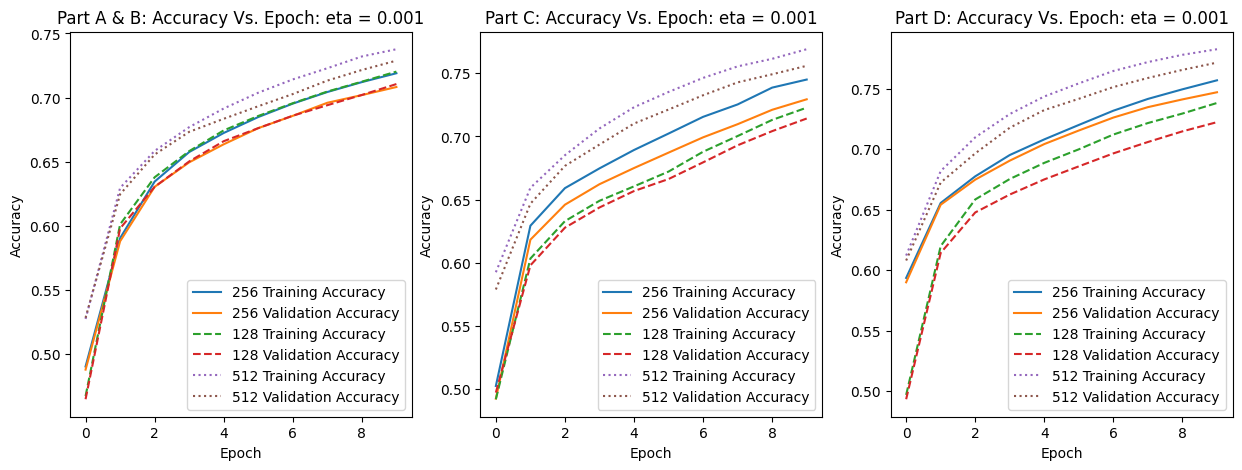

In [49]:
fig,axs = plt.subplots(1,3,figsize = (15,5))
axs[0].plot(mlpA.epochTrainingAccuracy,label = '256 Training Accuracy', linestyle = '-')
axs[0].plot(mlpA.epochValidationAccuracy,label = '256 Validation Accuracy',linestyle = '-')
axs[0].plot(mlpB128.epochTrainingAccuracy,label = '128 Training Accuracy',linestyle = "--")
axs[0].plot(mlpB128.epochValidationAccuracy,label = '128 Validation Accuracy',linestyle = '--')
axs[0].plot(mlpB512.epochTrainingAccuracy,label = '512 Training Accuracy',linestyle = ':')
axs[0].plot(mlpB512.epochValidationAccuracy,label = '512 Validation Accuracy',linestyle = ':')
axs[0].set_title(f'Part A & B: Accuracy Vs. Epoch: eta = {learning_rate}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(mlpC256.epochTrainingAccuracy,label = '256 Training Accuracy', linestyle = '-')
axs[1].plot(mlpC256.epochValidationAccuracy,label = '256 Validation Accuracy',linestyle = '-')
axs[1].plot(mlpC128.epochTrainingAccuracy,label = '128 Training Accuracy',linestyle = "--")
axs[1].plot(mlpC128.epochValidationAccuracy,label = '128 Validation Accuracy',linestyle = '--')
axs[1].plot(mlpC512.epochTrainingAccuracy,label = '512 Training Accuracy',linestyle = ':')
axs[1].plot(mlpC512.epochValidationAccuracy,label = '512 Validation Accuracy',linestyle = ':')
axs[1].set_title(f'Part C: Accuracy Vs. Epoch: eta = {learning_rate}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

axs[2].plot(mlp256_Dropout.epochTrainingAccuracy,label = '256 Training Accuracy', linestyle = '-')
axs[2].plot(mlp256_Dropout.epochValidationAccuracy,label = '256 Validation Accuracy',linestyle = '-')
axs[2].plot(mlp128_Dropout.epochTrainingAccuracy,label = '128 Training Accuracy',linestyle = "--")
axs[2].plot(mlp128_Dropout.epochValidationAccuracy,label = '128 Validation Accuracy',linestyle = '--')
axs[2].plot(mlp512_Dropout.epochTrainingAccuracy,label = '512 Training Accuracy',linestyle = ':')
axs[2].plot(mlp512_Dropout.epochValidationAccuracy,label = '512 Validation Accuracy',linestyle = ':')
axs[2].set_title(f'Part D: Accuracy Vs. Epoch: eta = {learning_rate}')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Accuracy')
axs[2].legend()
plt.show()
#plt.legend()
#plt.show()
#plt.plot(mlpB512.epochLoss,label = '512 hidden')
#plt.plot(mlpB128.epochLoss,label = '128 hidden')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.title(f'Loss vs Epoch; eta = {learning_rate}')
#plt.legend()
#plt.show()
